In [1]:
# Import standard modules

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as ss
import astropy.constants as con

# Import pymsg and pygyre

import pymsg
import pygyre

# Set constants

SIGMA = con.sigma_sb.cgs.value

# Set plot parameters

plt.rcParams.update({'font.size': 12})

In [2]:
def synthesize_light_curve(photgrid_file, phi, i):
    
    # Create the PhotGrid object

    photgrid = pymsg.PhotGrid(photgrid_file)
    
    # Read the GYRE output file into a table

    tbl = pygyre.read_output('summary.h5')
    
    # Select the table row corresponding to the l=m=2, g_30 mode
    
    mask = (tbl['l'] == 2) & (tbl['m'] == 2) & (tbl['n_pg'] == -30)

    row = tbl[mask][0]
    
    # Extract stellar parameters

    M_star = row['M_star']
    R_star = row['R_star']
    L_star = row['L_star']

    Teff = (L_star/(4*np.pi*SIGMA*R_star**2))**0.25
    g = con.G.cgs.value*M_star/R_star**2
                                  
    # Extract surface perturbation parameters (the T03
    # annotations indicate which equation from Townsend 2003
    # is being implemented)

    l = row['l']
    m = row['m']
    
    omega = row['omega']

    dR_R = row['xi_r_ref']      # Delta_R (T03, eqn. 4)
    dL_L = row['lag_L_ref']
    dT_T = 0.25*(dL_L - 2*dR_R) # Delta_T (T03, eqn. 5)
    dg_g = -(2 + omega**2)*dR_R # Delta_g (T03, eqn. 6)
    
    # Evaluate photometric P-moments & their partial derivatives 
    # (T03, eqn. 15; the I_{l;x} in that equation is equivalent to
    # P_l here)

    x = {'Teff': Teff, 'log(g)': np.log10(g)}

    P_0 = photgrid.P_moment(x, 0)
    P_l = photgrid.P_moment(x, l)

    dP_l_dlnT = photgrid.P_moment(x, l, deriv={'Teff': True}) * Teff
    dP_l_dlng = photgrid.P_moment(x, l, deriv={'log(g)': True}) * np.log(np.exp(1.))

    # Set up differential flux functions (T03, eqns. 12-14)

    R_lm = (2+l)*(1-l) * P_l/P_0 * ss.sph_harm(m, l, 0., i)
    T_lm = dP_l_dlnT/P_0 * ss.sph_harm(m, l, 0., i)
    G_lm = dP_l_dlng/P_0 * ss.sph_harm(m, l, 0., i)
    
    # Construct the light curve (T03, eqn. 11)

    dF_F = ((dR_R*R_lm + dT_T*T_lm + dg_g*G_lm) * np.exp(1j*phi)).real

    # Return it
    
    return dF_F

In [3]:
# Set up phase array

phi = np.linspace(0, 4*np.pi, 101)

# Set stellar inclination

i = np.radians(75)

# Evaluate light curves

dF_F_Kepler = synthesize_light_curve('pg-Kepler.h5', phi, i)
dF_F_TESS = synthesize_light_curve('pg-TESS.h5', phi, i)
dF_F_Gaia_B = synthesize_light_curve('pg-Gaia-B.h5', phi, i)
dF_F_Gaia_R = synthesize_light_curve('pg-Gaia-R.h5', phi, i)
dF_F_JWST = synthesize_light_curve('pg-JWST.h5', phi, i)

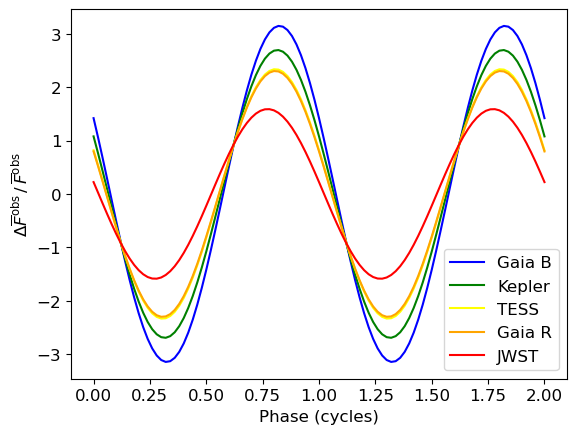

In [4]:
# Plot light curves

plt.figure()

plt.plot(phi/(2*np.pi), dF_F_Gaia_B, label='Gaia B', color='blue')
plt.plot(phi/(2*np.pi), dF_F_Kepler, label='Kepler', color='green')
plt.plot(phi/(2*np.pi), dF_F_TESS, label='TESS', color='yellow')
plt.plot(phi/(2*np.pi), dF_F_Gaia_R, label='Gaia R', color='orange')
plt.plot(phi/(2*np.pi), dF_F_JWST, label='JWST', color='red')

plt.xlabel('Phase (cycles)')
plt.ylabel(r'$\Delta \overline{F}^{\mathrm{obs}}\,/\,\overline{F}^{\mathrm{obs}}$')
plt.legend();